# Johnson and Shot Noise Analysis (2024)

#### This template assumes use of the new shot noise source

Use this template to carry out the analysis tasks for the Noise experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.
## First, import some packages

This is a good idea at the beginning of your notebook to include the packages that you will need.  We will use those shown below here.  A brief description:
* `numpy` is the foundational package for Python numerical work. It extends and speeds up array operations beyond standard Python, and it includes almost all math functions that you would need for example `sqrt()` (square root) or `cos()` (cosine).  These would be written in code as `np.sqrt()` or `np.cos()`.
* `scipy` is a huge collection of scientific data analysis functions, routines, physicical constants, etc.  This is the second most used package for scientific work. Here we will use the physical constants library, `scipy.constants`.  Documentation is at [SciPy.org](https://docs.scipy.org/doc/scipy/reference/) with the constants subpackage at https://docs.scipy.org/doc/scipy/reference/constants.html.
* `uncertainties` is a very useful small package that simplifies uncertainty propagation and printing out of quantities with uncertainty. Documentation is at https://pythonhosted.org/uncertainties/
* `matplotlib` is *the* standard plotting package for scientific Python.  We will use a subset called `pyplot` which is modeled after the plotting functions used in MATLAB. The last line below, `%matplotlib inline`, simply forces the plots to appear within the notebook.
* `pandas` is a large data science package.  It's main feature is a set of methods to create and manipulate a "DataFrame," which is an enlargement of the idea of an array.  I plays well with NumPy and other packages.  We will use it mainly as a way to read files into data sets in an easy way.

We will also use the [LMFit](https://lmfit.github.io/lmfit-py/) package to make line fits.  This will be explained later in the notebook.

In [226]:
from json.decoder import NaN

# Run this cell with Shift-Enter, and wait until the
# asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import pandas
import scipy.constants as const
import uncertainties as unc
import matplotlib.pyplot as plt
import pandas as pd
import re as re
import mplcyberpunk
from numpy.f2py.auxfuncs import throw_error
from numpy.ma.core import size
from uncertainties import ufloat
from uncertainties.unumpy import uarray
%matplotlib inline

plt.style.use('cyberpunk')

## Johnson Noise Analysis

## Exercise 1 -  Data reduction

> ### Read in the raw data
>
> **About Data Files:** This template assumes that the data files will have one of two types of structure:
> 1. If you took 5 readings (or so) for each measurement and plan to average them here, the assumed structure is one where each spreadsheet column is named with the resistance (for > Johnson Noise), e.g., "9.99k", or the emission current (for shot noise), e.g., "0.1047mA" and each row of the data is one trial with each cell containing the measured RMS voltage > in the frequency band;
> 2. If you opted instead to simply take one longer-average time measurement for each resistance (or emission current), then the assumed structure would be two columns, the first > column headed with resistance (or emission current) and the second column headed with the measured RMS voltage in the frequency band.
>
> Below, these structures are treated by the designation "1" or "2".  Stucture type "1" requires a little more effort to reduce, but offers the option of calculating data point > uncertainties.
>
> **Advice:** Use the **Pandas** function `read_csv()` to pull the file into a Pandas Dataframe, like this:
>
>     johnson_294 = pd.read_csv('Johnson_294K.csv')

> If the last line in the code cell is the name of the DataFrame (`johnson_294`), the notebook cell will print a nice table.

> You may obtain the arrays for each column by using the column label, e.g., `johnson_294['40.0k']` is the array of the first column.

For Johnson shot noise, we went about taking data manually and averaging it.

In [227]:
# This is to import the data as a raw pd dataframe.

johnson_294 = pd.read_csv('rawData/Johnson data - Johnson_Room_jupyter.csv')
johnson_294  # DataFrame name on the last line spits out a table

,40k,20k,15k,9.99k,7.5k,4.99k,2.5k,1.0k,0.0K
0,0.007909,0.005793,0.005050,0.004211,0.003701,0.002997,0.002196,0.001457,0.000620
1,0.007962,0.005885,0.005047,0.004180,0.003633,0.003006,0.002207,0.001484,0.000624
2,0.007796,0.005765,0.005031,0.004170,0.003611,0.002980,0.002148,0.001482,0.000615
3,0.007801,0.005848,0.005163,0.004190,0.003652,0.003037,0.002192,0.001496,0.000629
4,0.007821,0.005864,0.005107,0.004182,0.003747,0.002973,0.002194,0.001473,0.000625


### Massage the raw data

> #### For data structure type "1."  If you have a type "2" data structure, skip to "Plot the Reduced Data" below.
>
> Create new arrays that have averages of the 5 readings at each value of the resistance and their standard deviation.  Then extract the resistance from the column label and make > into a number.  Finally, build a new DataFrame that has these arrays. Below is an example.  The example shows a number of useful operations.  Study it carefully.
>
> We will use a loop to build the new arrays first, and then combine them into a DataFrame.
>
> You can extract the resistance from the column heading. Here is one way to do it, assuming `col_label` is the column label:
>
>     resistance = float(col_label.split('k')[0])
>
> This splits the label at `k` and puts the number into the first (0) position as a string.  `float()` converts the number string to a flaoting point number.
>
> Then calculate the mean and standard deviation using the built-in methods for the arrays.

In [228]:
## Study this example.

# These lines create empty arrays that will be filled.
Rs = np.zeros(0)
Vs = np.zeros(0)
Stds = np.zeros(0)

# This is a standard Python loop.  Note the 'for <item> in <list>:' construction
# The '.columns' is an array of column labels in the DataFrame
for label in johnson_294.columns:
    # obtain the numerical part of the column label
    # R = float(label.split('k')[0])
    R = float(re.split(r"(?i)k", label)[0])
    # calculate the mean (average) of the numbers in the column
    mean = johnson_294[label].mean()
    # calculate the standard deviation of the same numbers
    std = johnson_294[label].std()

    # These lines add each calculated result to the associated array
    Rs = np.append(Rs,R)
    Vs = np.append(Vs,mean)
    Stds = np.append(Stds,std)

Rs

# Initialize an empty DataFrame
J_294 = pd.DataFrame()

# These lines add columns to the DataFrame
J_294['R (ohms)'] = Rs*1000.0 # Convert resistance from kohms to ohms
J_294['Vrms (V)'] = Vs
J_294['DV (V)'] = Stds

# Here is another way to do the same thing

J_294_ver2 = pd.DataFrame({
    'R (ohms)': Rs*1e3,
    'Vrms (V)': Vs,
    'DV (V)': Stds
})

# Finally display the results.  Name of DataFrame on last line spits a table
# J_294
J_294_ver2


,R (ohms),Vrms (V),DV (V)
0,40000.0,0.007858,0.000074
1,20000.0,0.005831,0.000050
2,15000.0,0.005080,0.000055
3,9990.0,0.004187,0.000015
4,7500.0,0.003669,0.000055
5,4990.0,0.002999,0.000025
6,2500.0,0.002187,0.000023
7,1000.0,0.001478,0.000015
8,0.0,0.000623,0.000005


#### Repeat for the other temperature 

> Now you try it for the other temperature data set.

In [229]:
## Read in the data set and display it
johnson_ln2 = pd.read_csv("rawData/Johnson data - Johnson_ln2_jupyter.csv")
johnson_ln2

,40k,20k,15k,9.99k,7.5k,4.99k,2.5k,1.0k,0.0k
0,0.004315,0.003218,0.002730,0.002270,0.002021,0.001781,0.001299,0.000932,0.000627
1,0.004319,0.003168,0.002759,0.002272,0.001994,0.001776,0.001246,0.000927,0.000627
2,0.004299,0.003138,0.002712,0.002264,0.001972,0.001746,0.001243,0.000947,0.000617
3,0.004424,0.003201,0.002749,0.002202,0.002000,0.001729,0.001265,0.000941,0.000623
4,0.004292,0.003161,0.002731,0.002289,0.002032,0.001765,0.001260,0.000944,0.000628
5,0.004286,0.003098,0.002715,0.002254,0.001981,0.001732,0.001245,0.000929,0.000622


In [230]:
## Calculate the averages of each column.
## extract the values of the resistance.  
## Build a (new) dataframe and display it to see if it looks right.
# These lines create empty arrays that will be filled.
Rs = np.zeros(0)
Vs = np.zeros(0)
Stds = np.zeros(0)

# This is a standard Python loop.  Note the 'for <item> in <list>:' construction
# The '.columns' is an array of column labels in the DataFrame
for label in johnson_ln2.columns:
    # obtain the numerical part of the column label
    # R = float(label.split('k')[0])
    R = float(re.split(r"(?i)k", label)[0])
    # calculate the mean (average) of the numbers in the column
    mean = johnson_ln2[label].mean()
    # calculate the standard deviation of the same numbers
    std = johnson_ln2[label].std()

    # These lines add each calculated result to the associated array
    Rs = np.append(Rs,R)
    Vs = np.append(Vs,mean)
    Stds = np.append(Stds,std)


J_ln2 = pd.DataFrame({
    'R (ohms)': Rs*1e3,
    'Vrms (V)': Vs,
    'DV (V)': Stds
})

J_ln2


,R (ohms),Vrms (V),DV (V)
0,40000.0,0.004322,0.000051
1,20000.0,0.003164,0.000043
2,15000.0,0.002733,0.000018
3,9990.0,0.002258,0.000030
4,7500.0,0.002000,0.000023
5,4990.0,0.001755,0.000022
6,2500.0,0.001260,0.000021
7,1000.0,0.000937,0.000008
8,0.0,0.000624,0.000004


### Plot the reduced data

> Plot the data set of $V_{rms}$ vs $R$ to see what it looks like.
>
> Below, I'll show how. Study the commands, change them, and see what happens.  Hint: study the sections in the [Python Data Science Handbook](https://jakevdp.github> .io/PythonDataScienceHandbook/) on Matplotlib.
>
> After you make the plot, always look to make sure your data set does not have any weird points. This is a good way to catch bad data and/or mistakes.

In [231]:
# Set up plot defaults  This cell only needs to be executed once.
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 12.0 # Use 12 point font

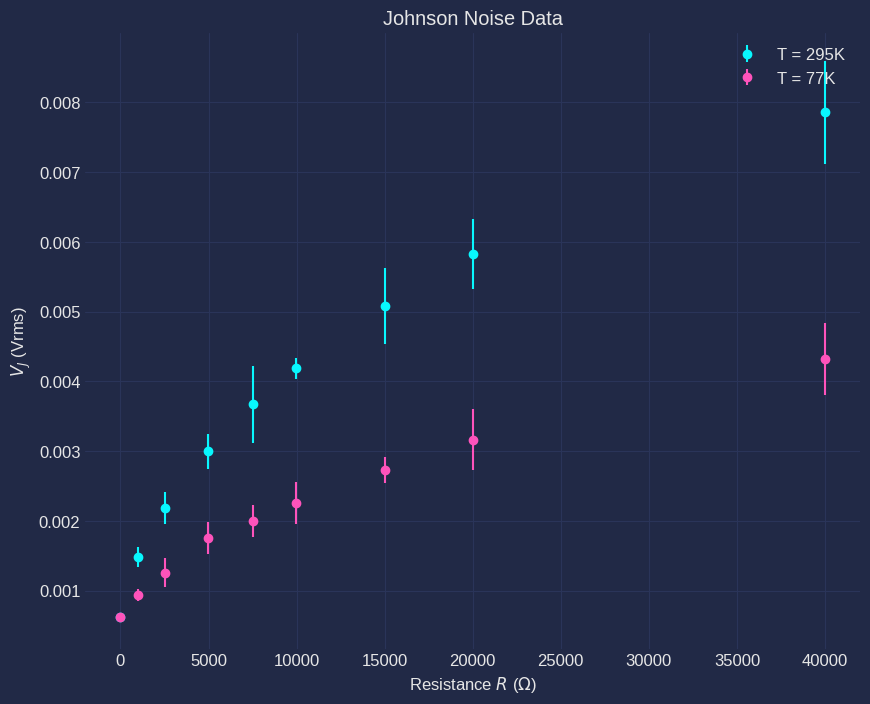

In [232]:
## Plot the data sets on one graph
## Header commands provided


fig, ax = plt.subplots()

ax.set_title('Johnson Noise Data')
ax.set_xlabel(r'Resistance $R$ ($\Omega$)')
ax.set_ylabel(r'$V_J$ (Vrms)')
ax.grid(color='#2A3459')



# plt.grid() # Turn on the grid
# plt.title('Johnson Noise Data') # make a plot title
# plt.ylabel(r'$V_J$ (Vrms)') # Make an axis label.  Note the $$ to typeset math
# plt.xlabel(r'Resistance $R$ ($\Omega$)') #Another axis label

# Below shows how to make a plot with error bars.  The errors are multiplied by 
# 10 so that the bars are visible. 

# If you have no error bars, simply omit the item 'yerr=J_294['DV (V)']*10'

ax.errorbar(J_294['R (ohms)'],J_294['Vrms (V)'],
             yerr=J_294['DV (V)']*10,
             fmt='o',label='T = 295K')

ax.errorbar(J_ln2['R (ohms)'], J_ln2['Vrms (V)'],
             yerr=J_ln2['DV (V)'] * 10,
             fmt='o', label='T = 77K')

ax.legend(); # Make a legend


### Include the other data

> Repeat the lines in the cell above and include another data set so that both the 395K and 77K data are on the same plot.

In [233]:
## This code was refactored to above.

# ## Plot the data sets on one graph
# ## Header commands provided
#
# # Below shows how to make a plot with error bars.  The errors are multiplied by
# # 10 so that the bars are visible.
#
# # If you have no error bars, simply omit the item 'yerr=J_294['DV (V)']*10'
#
# plt.errorbar(J_ln2['R (ohms)'], J_ln2['Vrms (V)'],
#              yerr=J_ln2['DV (V)'] * 10,
#              fmt='o', label='T = 295K')
# plt.legend();  # Make a legend


## Exercise 2

>### Part a.  Modify the data

>Modify the data arrays to obtain the mean square voltages for each temperature, and also the difference in the (squared) data for the two temperatures, which will help remove the effects of noise in the electronics.  **Remember:** You have NumPy/Pandas arrays, so you can do each task with a single line of code.

>Then plot the results, all on one plot so you can compare them visually.

>#### For data sets that have uncertainties associated with them.

>If you have uncertainties on each data point that you want to carry forward in the analysis, when you square the value, the uncertainty is NOT also squared. Instead it is multiplied by 2 times the |value|.  That is, if $\sigma_x$ is the uncertainty in $x$, the uncertainty in $x^2$ is $\sigma_{x^2} = 2|x|\sigma_x$.

>Another way to work out the uncertainties is to first build arrays of uncertainty objects from the data and uncertainty arrays. For example, if the data are in an array called `X` and the uncertainty (i.e., error bars) are in an array called `sigma_X`, you can build an uncertainty array as follows:

>    # Import uNumPy functions.  You could do this in the first cell
>    import uncertainties.unumpy as unp
>
>    # Build an uncertainty array
>    uX = unp.uarray(X, sigma_X)
>
>    # Square the array, and also propagate uncertainty
>    uX_sqrd = uX*uX
>
>    # Access the parts of the uncertainty array.  This is necessary for curve fitting
>    uX_sqrd_values = unp.nominal_values(uX_sqrd)
>    uX_sqrd_sigmas = unp.std_devs(uX_sqrd)

In [234]:
## Modify the arrays as specified above
# Lets create the specified data:
import uncertainties.unumpy as unp

# Lets start by viewing what is in the arrays

johnson_294

,40k,20k,15k,9.99k,7.5k,4.99k,2.5k,1.0k,0.0K
0,0.007909,0.005793,0.005050,0.004211,0.003701,0.002997,0.002196,0.001457,0.000620
1,0.007962,0.005885,0.005047,0.004180,0.003633,0.003006,0.002207,0.001484,0.000624
2,0.007796,0.005765,0.005031,0.004170,0.003611,0.002980,0.002148,0.001482,0.000615
3,0.007801,0.005848,0.005163,0.004190,0.003652,0.003037,0.002192,0.001496,0.000629
4,0.007821,0.005864,0.005107,0.004182,0.003747,0.002973,0.002194,0.001473,0.000625


In [235]:
# Let's start by forming the uncertainty objects:
J_294['Vrms (V) unc'] = unp.uarray(J_294['Vrms (V)'], J_294['DV (V)'])
J_ln2['Vrms (V) unc'] = unp.uarray(J_ln2['Vrms (V)'], J_ln2['DV (V)'])

# Now lets square the values
J_294['Vms (V)'] = J_294['Vrms (V) unc'] ** 2
J_ln2['Vms (V)'] = J_ln2['Vrms (V) unc'] ** 2

# Finally lets take the difference of 295k and 77k
J_diff = pd.DataFrame({'R (ohms)' : J_294['R (ohms)']})
J_diff['Vms (V) diff'] = J_294['Vms (V)'] - J_ln2['Vms (V)']

J_294
J_diff


,R (ohms),Vms (V) diff
0,40000.0,(4.31+/-0.12)e-05
1,20000.0,(2.40+/-0.06)e-05
2,15000.0,(1.83+/-0.06)e-05
3,9990.0,(1.243+/-0.019)e-05
4,7500.0,(9.5+/-0.4)e-06
5,4990.0,(5.91+/-0.17)e-06
6,2500.0,(3.20+/-0.11)e-06
7,1000.0,(1.31+/-0.05)e-06
8,0.0,(-1+/-8)e-09


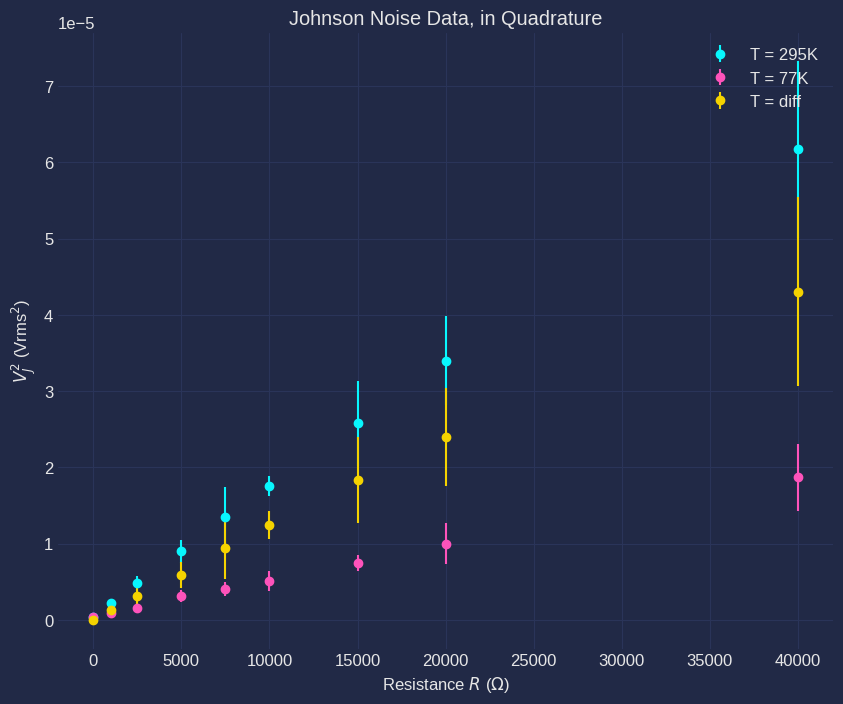

In [236]:
## Plot the results
## Header commands provided to format plot
## Uncertainties here are also 10xed to be visible on the plot.
fig_quad, ax_quad = plt.subplots()
ax_quad.grid(color='#2A3459')
ax_quad.set_title('Johnson Noise Data, in Quadrature')
ax_quad.set_ylabel(r'$V^2_J$ (Vrms$^2$)')
ax_quad.set_xlabel(r'Resistance $R$ ($\Omega$)')
## Add your code here
ax_quad.errorbar(J_294['R (ohms)'],
                 unp.nominal_values(J_294['Vms (V)']),
                 unp.std_devs(J_294['Vms (V)']) * 10,
                 label='T = 295K', fmt='o')

ax_quad.errorbar(J_ln2['R (ohms)'],
                 unp.nominal_values(J_ln2['Vms (V)']),
                 unp.std_devs(J_ln2['Vms (V)']) * 10,
                 label='T = 77K', fmt='o')
ax_quad.errorbar(J_diff['R (ohms)'],
                 unp.nominal_values(J_diff['Vms (V) diff']),
                 unp.std_devs(J_diff['Vms (V) diff']) * 10,
                 label='T = diff', fmt='o')

ax_quad.legend();

### Part b. Fit the modified data

>To fit the data set to a line, make use of the **LMFit** package. It is a useful add-on to the SciPy fitting functions.  This package simplifies fitting data to a variety of standard functions.  See the [Lmfit Documentation](https://lmfit.github.io/lmfit-py/index.html) for a full discussion.  The package is quite powerful, but for basic fitting with common functions, it is very easy to use.

>#### Example: Fitting a line

>The example below shows how to use the package to fit data to a line, obtain the fit parameters along with uncertainties, and then plot the data and fit. Execute the cells and study how it works.
>(Note: the data come from a calibration problem in physics 331)

In [237]:
# This cell only creates arrays of x and y data to feed to the fit example in the next cell.
# Calibration Data from a physics 331 experiment.
# First column is wavelength (nm), second is carriage position (cm)
#
Cal_data = np.array([
    [643.85, 41.43],
    [579.07, 37.24],
    [576.96, 37.11],
    [546.08, 35.10],
    [508.58, 32.68],
    [479.99, 30.83],
    [467.81, 30.04],
    [435.83, 27.96],
    [404.66, 25.98]])

# Array slicing separates x (position) and y (wavelength)
# Goal of calibration is to be able to feed in a position and obtain a wavelength
wavelength = Cal_data[:,0]
position = Cal_data[:,1]

The following cell executes the fitting calculations.

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 9
    # variables        = 2
    chi-square         = 0.18041902
    reduced chi-square = 0.02577415
    Akaike info crit   = -31.1872805
    Bayesian info crit = -30.7928313
    R-squared          = 0.99999620
[[Variables]]
    slope:      15.4639413 +/- 0.01139807 (0.07%) (init = 15.46394)
    intercept:  3.20598011 +/- 0.38164182 (11.90%) (init = 3.20598)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9901


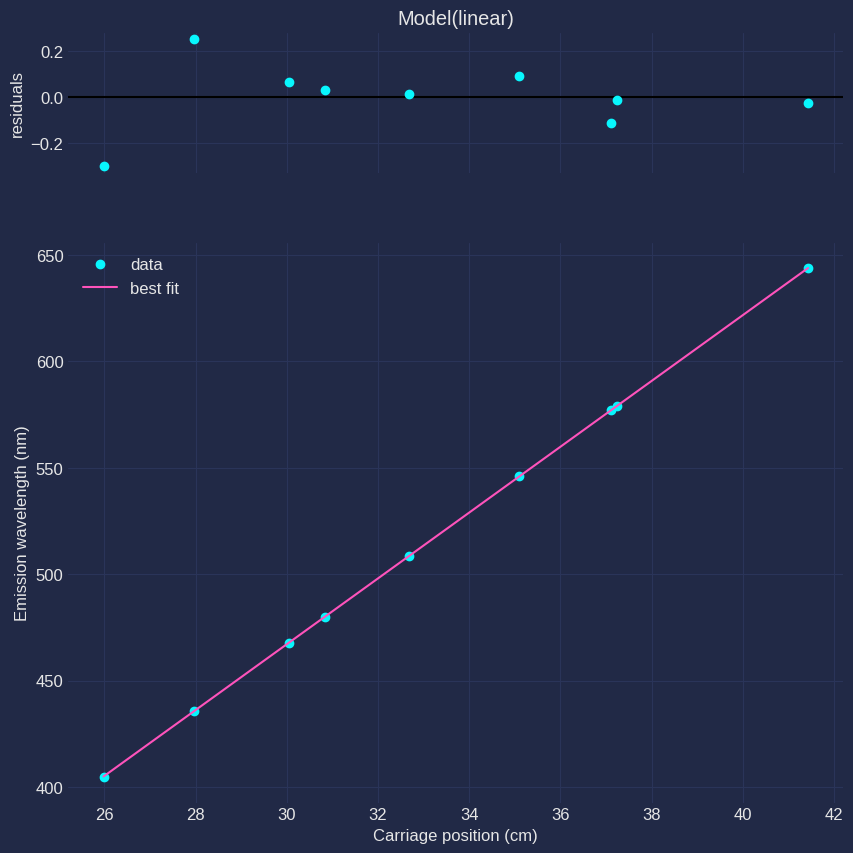

In [238]:
# imports a linear fitting model from lmfit  
# ONLY IMPORT ONCE IN A NOTEBOOK
from lmfit.models import LinearModel, DimensionalError

# create an instance of the model
# You only need to do this once in a notebook
line = LinearModel()

# One must have a guess of the parameters. The guess() method works with most of the standard
# lmfit models

# The return value is a Parameters structure.  See the documentation.
param_guess = line.guess(wavelength, x=position)

# The line below executes the fitting process.  The results are returned to "line_fit"
line_fit = line.fit(wavelength, param_guess, x=position)

# This prints the results in an easy to read form
print(line_fit.fit_report())

#Then you can plot the results quickly just to see how it looks using the plot() method
line_fit.plot()
# Optional: Change axis labels from default 'X' vs. 'Y'.
plt.xlabel('Carriage position (cm)')
plt.ylabel('Emission wavelength (nm)');

Fit each to a line and obtain the slope with uncertainty.  Plot the data with the fit lines.

First, I'll make functions to clean up the coding.

In [239]:
## Defines a function to do the work.  Study it.  If you don't understand how this works,
## find out by asking questions and or studying the functions in the code.

def line_fit_and_plot(xdata, ydata, yerr=None, model=LinearModel(), xlabel='X', ylabel='Y'):
    '''
    Fit a line or curve, and plot/show the fit results.
    The function returns a parameters object with the fit parameters
    '''
    param_guess = model.guess(ydata, x=xdata)
    if (yerr is None):
        model_fit = model.fit(ydata, param_guess, x=xdata)
    else:
        model_fit = model.fit(ydata, param_guess, x=xdata, weights=1/yerr)
    print(model_fit.fit_report(show_correl=False))
    model_fit.plot()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);
    return model_fit.params

## This function use the Uncertainties function to make an uncertainty object

def get_uslope(params):
    return unc.ufloat(params['slope'].value, params['slope'].stderr)

Then run the functions.

### First, for the 300k Data:

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 9
    # variables        = 2
    chi-square         = 42.9965765
    reduced chi-square = 6.14236807
    Akaike info crit   = 18.0750633
    Bayesian info crit = 18.4695124
    R-squared          = 0.98552059
[[Variables]]
    slope:      1.6997e-09 +/- 2.3043e-11 (1.36%) (init = 1.544299e-09)
    intercept:  3.9117e-07 +/- 1.5978e-08 (4.08%) (init = 1.438028e-06)

Slope = (1.700±0.023)×10⁻⁹


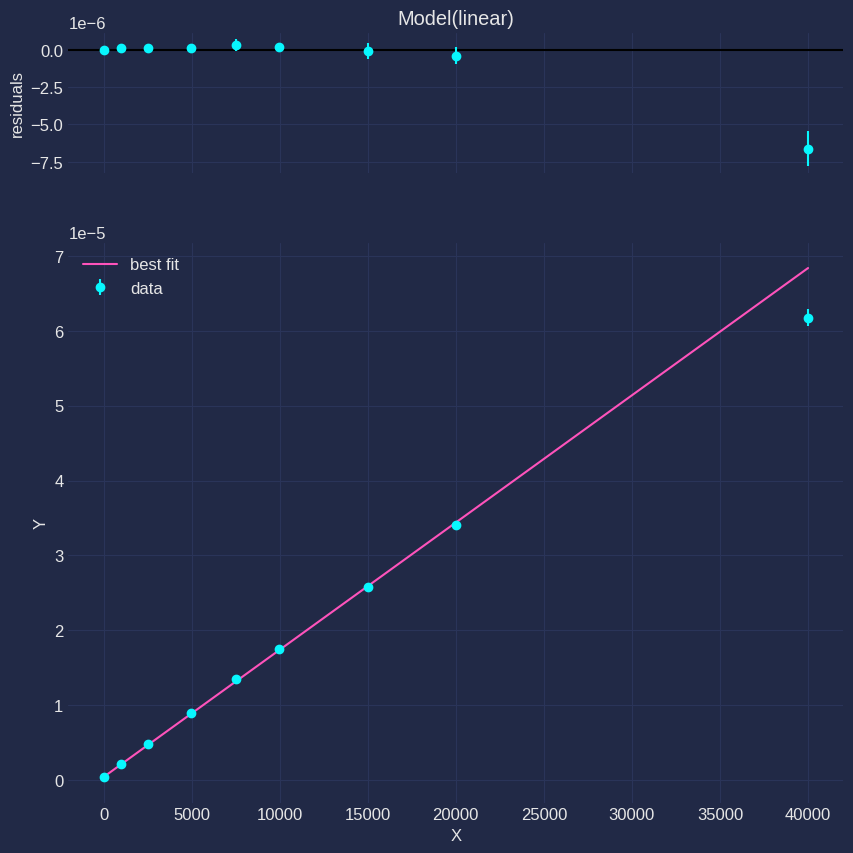

In [240]:
## Use the functions above to run the fit for the modified 295K data
## and save the fit parameters.  Then pull out the slope
## Here is how you would use the above functions with the example data:

# Run the fit
# example_fit_params = line_fit_and_plot(position,wavelength,
#                                        xlabel='Carriage position (cm)',ylabel='Emission wavelength (nm)')

J_294_fit_params = line_fit_and_plot(J_294['R (ohms)'],
                                     unp.nominal_values(J_294['Vms (V)']),
                                     unp.std_devs(J_294['Vms (V)']),)


# Obtain the slope and its uncertainty into an uncertainty object
# slope_with_uncertainty = get_uslope(example_fit_params)
slope_with_uncertainty = get_uslope(J_294_fit_params)
print('\nSlope = {:.2uP}'.format(slope_with_uncertainty))


### For the 77k Data

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 9
    # variables        = 2
    chi-square         = 19.9694049
    reduced chi-square = 2.85277212
    Akaike info crit   = 11.1727909
    Bayesian info crit = 11.5672401
    R-squared          = 0.99715304
[[Variables]]
    slope:      4.7755e-10 +/- 7.1432e-12 (1.50%) (init = 4.580018e-10)
    intercept:  3.9135e-07 +/- 8.4604e-09 (2.16%) (init = 5.496959e-07)

Slope = (4.776±0.071)×10⁻¹⁰


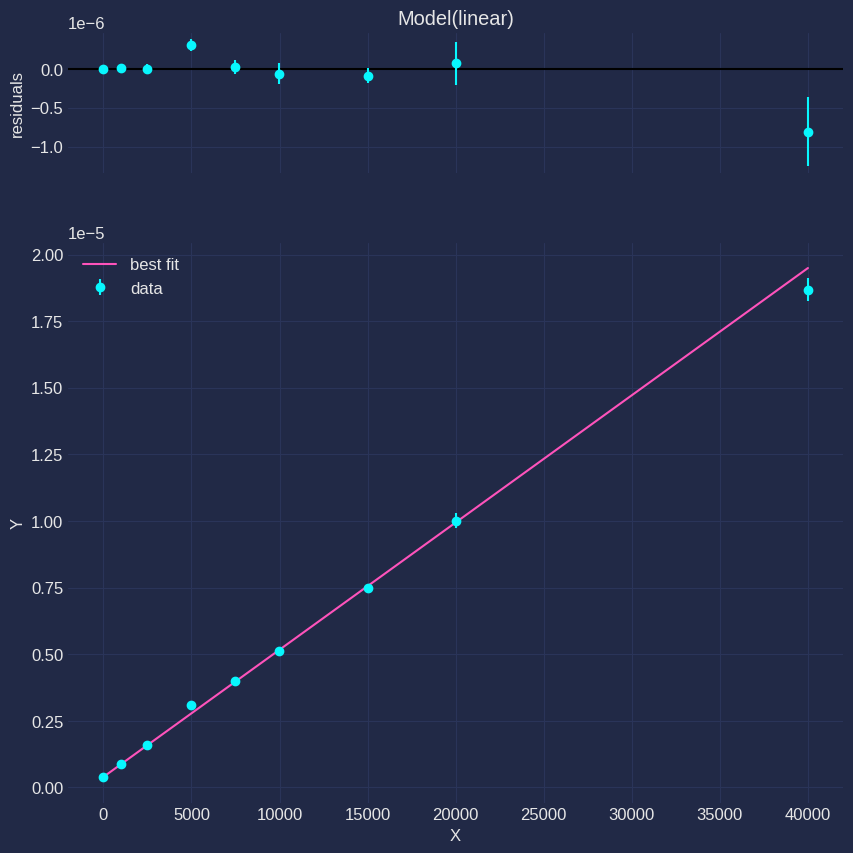

In [241]:
J_ln2_fit_params = line_fit_and_plot(J_ln2['R (ohms)'],
                                     unp.nominal_values(J_ln2['Vms (V)']),
                                     unp.std_devs(J_ln2['Vms (V)']),)


# Obtain the slope and its uncertainty into an uncertainty object
# slope_with_uncertainty = get_uslope(example_fit_params)
slope_with_uncertainty = get_uslope(J_ln2_fit_params)
print('\nSlope = {:.2uP}'.format(slope_with_uncertainty))

### For the Diff Data


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 9
    # variables        = 2
    chi-square         = 30.0805152
    reduced chi-square = 4.29721646
    Akaike info crit   = 14.8598775
    Bayesian info crit = 15.2543266
    R-squared          = 0.97983080
[[Variables]]
    slope:      1.2139e-09 +/- 2.3781e-11 (1.96%) (init = 1.086297e-09)
    intercept:  2.6615e-09 +/- 1.7086e-08 (641.99%) (init = 8.883324e-07)

Slope = (1.214±0.024)×10⁻⁹


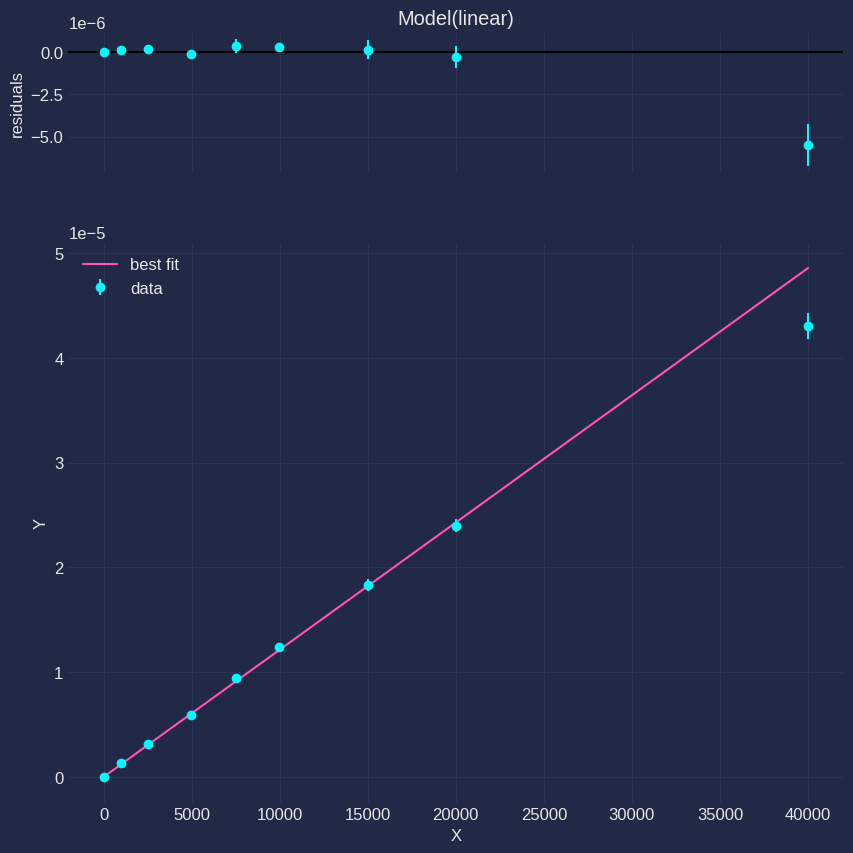

In [242]:

# Finally for the diff dataset"

J_diff_fit_params = line_fit_and_plot(J_diff['R (ohms)'],
                                     unp.nominal_values(J_diff['Vms (V) diff']),
                                     unp.std_devs(J_diff['Vms (V) diff']),)


# Obtain the slope and its uncertainty into an uncertainty object
# slope_with_uncertainty = get_uslope(example_fit_params)
slope_with_uncertainty = get_uslope(J_diff_fit_params)
print('\nSlope = {:.2uP}'.format(slope_with_uncertainty))

### Calculate a Boltzmann constant

From the results, calculate the implied Boltzmann constant (with uncertainty).

Revised gain of low-noise amplifier $G=10122\pm35$ (as of July 2021, DBP)

In [243]:
## Create uncertainties objects for the other quantities.  The first two are examples
T_295 = unc.ufloat(295.0,1.0) # K
G = unc.ufloat(10122,35) # unitless
k_B = const.Boltzmann # J/K Accepted value of Boltsmann constant from SciPy constants library.
# You do the rest

k_295 = get_uslope(J_294_fit_params) / (G**2 * 4 * T_295 * 1000)

## Calculate and print k_Boltzmann
# Use the following print line:
print('Boltzmann constant from T = 295K data = {:.2uP} J/K'.format(k_295))
print('Accepted value = {:.4g} J/K'.format(k_B))

1 / (4 * T_295 * 1000)

Boltzmann constant from T = 295K data = (1.406±0.022)×10⁻²³ J/K
Accepted value = 1.381e-23 J/K


8.474576271186441e-07+/-2.872737719046251e-09

### 77 K data
Repeat the process for the 77K data set.

In [244]:
## Repeat for the 77K data

T_77 = unc.ufloat(77.0,1.0)
k_ln2 = get_uslope(J_ln2_fit_params) / (G**2 * 4 * T_77 * 1000)

print('Boltzmann constant from T = 77K data = {:.2uP} J/K'.format(k_ln2))
print('Accepted value = {:.4g} J/K'.format(k_B))


Boltzmann constant from T = 77K data = (1.513±0.032)×10⁻²³ J/K
Accepted value = 1.381e-23 J/K


And finally, the difference data

In [245]:
## Repeat for the "difference" data (295K-77K) subracted in quadrature
T_diff = T_295 - T_77
k_diff = get_uslope(J_diff_fit_params) / (G**2 * 4 * T_diff * 1000)

print('Boltzmann constant from T = 77K data = {:.2uP} J/K'.format(k_diff))
print('Accepted value = {:.4g} J/K'.format(k_B))

Boltzmann constant from T = 77K data = (1.359±0.030)×10⁻²³ J/K
Accepted value = 1.381e-23 J/K


### Plot everything on one graph

Make a single plot that shows all three sets of data (as points) and the three fit lines (as lines).  Include a legend.

The cell below shows how to create a fit line using an arbitrary set of x-values based on the range of x data.  It uses the example data sets.

#### Recall
Let's start with the plot `ax_grid`, which, if we recall, is the graph with all the datapoints.
we have 3 sets of line data that we will now fit into these graphs:
* _295 300k
* _ln2 77k
* _diff difference in the data.

Lets view our original graph first:

In [246]:
## Lets replot based on the Gain.
# fig_john, ax_john = plt.subplots()
#
#
# ax_john.grid()
# ax_john.set_title('Johnson Noise Data, in Quadrature')
# ax_john.set_ylabel(r'$V^2_J$ (Vrms$^2$)')
# ax_john.set_xlabel(r'Resistance $R$ ($\Omega$)')
# ax_john.set_yli
# ax_john.autoscale(enable=True, axis=ax_john.get_yaxis())
# #
# ax_john.errorbar(J_294['R (ohms)'],
#                  unp.nominal_values(J_294['Vms (V)'] / G),
#                  unp.std_devs(J_294['Vms (V)']) * 10,
#                  label='T = 295K', fmt='o')

# ax_john.errorbar(J_ln2['R (ohms)'],
#                  unp.nominal_values(J_ln2['Vms (V)']),
#                  unp.std_devs(J_ln2['Vms (V)']) * 10,
#                  label='T = 77K', fmt='o')
# ax_john.errorbar(J_diff['R (ohms)'],
#                  unp.nominal_values(J_diff['Vms (V) diff']),
#                  unp.std_devs(J_diff['Vms (V) diff']) * 10,
#                  label='T = diff', fmt='o')

plt.show()


#### Adding Fit lines


In [247]:
type(J_294['R (ohms)'].min())

numpy.float64

In [248]:
# start with _294

xvalues_294 = np.linspace(J_294['R (ohms)'].min(), J_294['R (ohms)'].max(), 100)
yvalues_294 = line.eval(J_294_fit_params, x=xvalues_294)


xvalues_ln2 = np.linspace(J_ln2['R (ohms)'].min(), J_ln2['R (ohms)'].max(), 100)
yvalues_ln2 = line.eval(J_ln2_fit_params, x=xvalues_ln2)


xvalues_diff = np.linspace(J_diff['R (ohms)'].min(), J_diff['R (ohms)'].max(), 100)
yvalues_diff = line.eval(J_diff_fit_params, x=xvalues_diff)


yvalues_294

array([3.91171144e-07, 1.07791840e-06, 1.76466565e-06, 2.45141290e-06,
       3.13816015e-06, 3.82490740e-06, 4.51165466e-06, 5.19840191e-06,
       5.88514916e-06, 6.57189641e-06, 7.25864366e-06, 7.94539091e-06,
       8.63213817e-06, 9.31888542e-06, 1.00056327e-05, 1.06923799e-05,
       1.13791272e-05, 1.20658744e-05, 1.27526217e-05, 1.34393689e-05,
       1.41261162e-05, 1.48128634e-05, 1.54996107e-05, 1.61863579e-05,
       1.68731052e-05, 1.75598524e-05, 1.82465997e-05, 1.89333469e-05,
       1.96200942e-05, 2.03068414e-05, 2.09935887e-05, 2.16803360e-05,
       2.23670832e-05, 2.30538305e-05, 2.37405777e-05, 2.44273250e-05,
       2.51140722e-05, 2.58008195e-05, 2.64875667e-05, 2.71743140e-05,
       2.78610612e-05, 2.85478085e-05, 2.92345557e-05, 2.99213030e-05,
       3.06080502e-05, 3.12947975e-05, 3.19815447e-05, 3.26682920e-05,
       3.33550392e-05, 3.40417865e-05, 3.47285337e-05, 3.54152810e-05,
       3.61020282e-05, 3.67887755e-05, 3.74755227e-05, 3.81622700e-05,
      

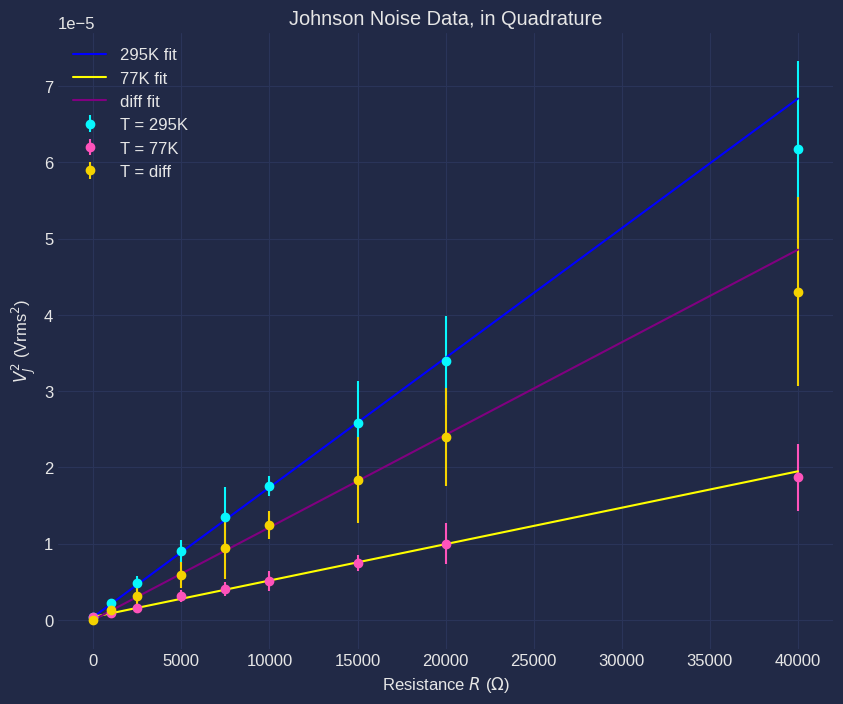

In [249]:
# Finally, we plot:

ax_quad.plot(xvalues_294, yvalues_294, color='blue', label='295K fit')
ax_quad.plot(xvalues_ln2, yvalues_ln2, color='yellow', label='77K fit')
ax_quad.plot(xvalues_diff, yvalues_diff, color='purple', label='diff fit')
ax_quad.legend()
ax_quad.grid(color='#2A3459')
# Let's also add the slope data:



display(fig_quad)

### Part c.

Summary of results for Boltsmann constant:

In [250]:
## Summarize the results in one table
## Like so:
print('  T (K)  |  k_B (J/K)   ')
print('---------|--------------------')
print('   295   | {:.1uP}'.format(k_295))
print('    77   | {:.1uP}'.format(k_ln2))
print(' 295-77  | {:.1uP}'.format(k_diff))
print('Accepted | {:10.4g}'.format(k_B))


  T (K)  |  k_B (J/K)   
---------|--------------------
   295   | (1.41±0.02)×10⁻²³
    77   | (1.51±0.03)×10⁻²³
 295-77  | (1.36±0.03)×10⁻²³
Accepted |  1.381e-23


## Exercise 3: Noise Figure

Calculate the "noise figure" for the low-noise amp, as described in the instructions.

The noise figure is defined:

$$ NF = 20\log_{10}\frac{V_{rms}(R)}{G\times\sqrt{4k_BTRB}} \; \text{dB}$$

Please limit the noise figure to 2 digits beyond the decimal point.  

Note: It clearly does not work for $R=0$.  You will need to leave this out of the calculations.

In [251]:

from uncertainties import umath
## Calculate the Noise figure for the various values of R at
## room temperature and display it as a table or a plot

## Lets define a function to handle everything for us:


In [252]:

def NF_calc(R, Vrms, T, gain = G, k_boltz = k_B):
    if (R == 0):
        return np.nan# For the 0 Edge Case
    return  Vrms / (gain * umath.sqrt(4 * k_boltz * T * R * 1000 ))

def nf_izer(target0, target1, temp):
    result = list()
    if len(target0) != len(target1):
        raise ValueError("Not the right length")
    for i in range(len(target0)):
        result.append(NF_calc(target0.iloc[i], target1.iloc[i], temp))
    return result

NF_294 = nf_izer(J_294['R (ohms)'], J_294['Vrms (V)'], T_295)
NF_ln2 = nf_izer(J_ln2['R (ohms)'], J_ln2['Vrms (V)'], T_77)
NF_diff = nf_izer(J_diff['R (ohms)'], J_diff['Vms (V) diff'].apply(np.abs).apply(umath.sqrt), T_diff)

summary = pd.DataFrame({'R (ohms)': J_294['R (ohms)'], 'nf_294' : NF_294, 'nf_ln2' : NF_ln2, 'nf_diff' : NF_diff})

summary
# first, lets create staging arrays
# NF_294 = np.zeros_like(J_294['R (ohms)'])
# NF_ln2 = np.zeros_like(J_ln2['R (ohms)'])
# NF_diff = np.zeros_like(J_diff['R (ohms)'])

# now,


# Next we'll create a smplified dataframe
# big = pd.DataFrame({'R (ohms)': J_294['R (ohms)'],
#                         'Vrms (V)_294': J_294['Vrms (V)'],
#                         'Vrms (V)_ln2': J_ln2['Vrms (V)'],
#                         'Vrms (V)_diff': J_diff['Vms (V) diff'].apply(np.abs).apply(unp.sqrt),
#                     })
# big

/home/coyotedark/Documents/uw/phys/431/johnson-and-shot-noise-main/.venv/lib/python3.14/site-packages/pandas/core/internals/blocks.py:347: FutureWarning: AffineScalarFunc.__abs__() is deprecated. It will be removed in a future release.
  result = func(self.values, **kwargs)


,R (ohms),nf_294,nf_ln2,nf_diff
0,40000.0,0.962+/-0.004,1.035+/-0.008,0.934+/-0.014
1,20000.0,1.009+/-0.004,1.072+/-0.008,0.986+/-0.014
2,15000.0,1.015+/-0.004,1.069+/-0.008,0.995+/-0.016
3,9990.0,1.025+/-0.004,1.083+/-0.008,1.004+/-0.009
4,7500.0,1.037+/-0.004,1.106+/-0.008,1.011+/-0.023
5,4990.0,1.039+/-0.004,1.190+/-0.009,0.980+/-0.015
6,2500.0,1.071+/-0.004,1.207+/-0.009,1.018+/-0.019
7,1000.0,1.144+/-0.004,1.419+/-0.010,1.030+/-0.019
8,0.0,NaN,NaN,NaN


## Shot Noise Analysis

> This is very similar to the Johnson noise analysis.

### Read in the data

> For data structure type "1", column names like "0.1202mA" need to split at `m` to convert the current labels into currents.


For the Shot Noise data, due to the battery constraints, we opted for the automated collection of averages. This, however, means we do not have the standard deviation. This means uncertainties will not be reported.

In [273]:
shot = pd.read_csv('./rawData/Johnson data - shot.csv')
shot = shot.rename(columns={'Emission Current' : 'Emission Current (A)', 'Avr' : 'Average (Vrms)'}, errors='raise')
shot['Emission Current (A)'] = shot["Emission Current (A)"] / 1000


shot

,Emission Current (A),Average (Vrms)
0,0.000000,0.004807
1,0.000010,0.007450
2,0.000011,0.007873
3,0.000012,0.008101
4,0.000013,0.008657
5,0.000014,0.008493
6,0.000015,0.008643
7,0.000020,0.009940
8,0.000030,0.011280
9,0.000040,0.012660


### Plot the raw data

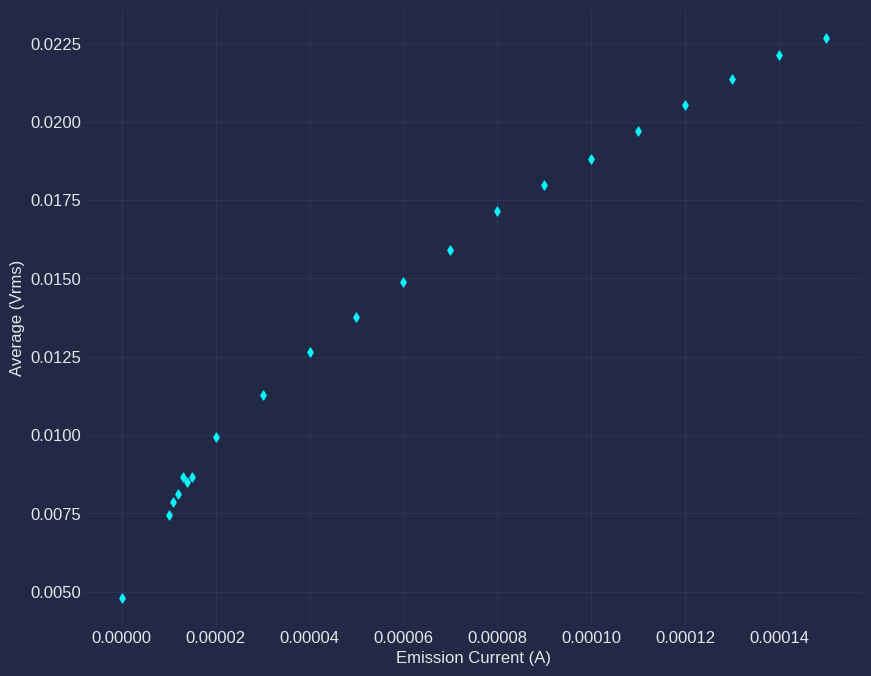

In [274]:
## Plot it

fig = shot.plot.scatter('Emission Current (A)', 'Average (Vrms)', marker='d')
ax = fig.axes


### Calculate $V^2_{rms}$

In [275]:
## transform the data, like you did with Johnson noise
shot['Vms'] = shot["Average (Vrms)"]**2
shot

,Emission Current (A),Average (Vrms),Vms
0,0.000000,0.004807,0.000023
1,0.000010,0.007450,0.000056
2,0.000011,0.007873,0.000062
3,0.000012,0.008101,0.000066
4,0.000013,0.008657,0.000075
5,0.000014,0.008493,0.000072
6,0.000015,0.008643,0.000075
7,0.000020,0.009940,0.000099
8,0.000030,0.011280,0.000127
9,0.000040,0.012660,0.000160


<Axes: xlabel='Emission Current (A)', ylabel='Vms'>

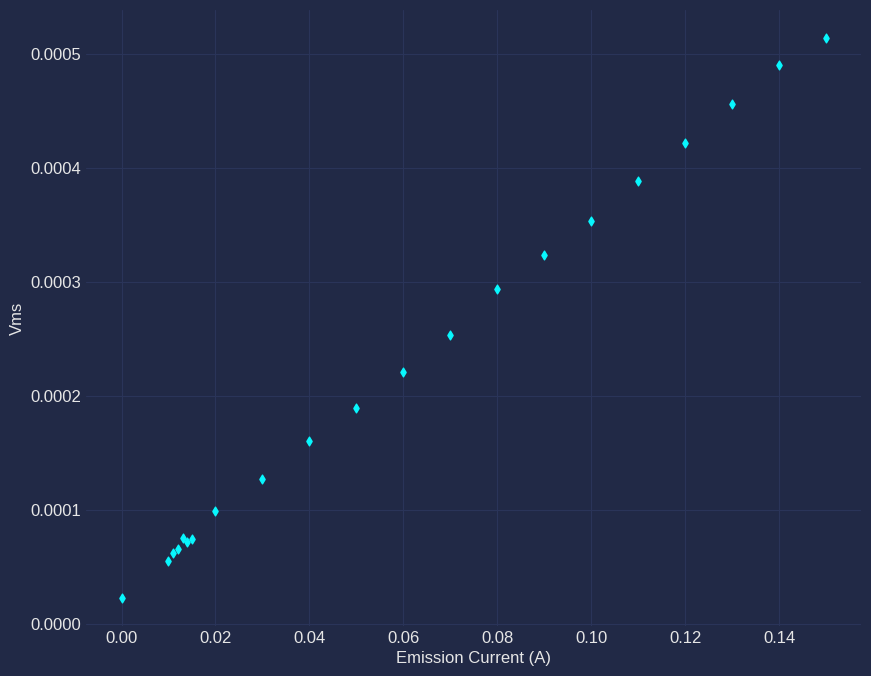

In [256]:
shot.plot.scatter('Emission Current (A)', 'Vms', marker='d')

### Then fit it and plot it

**Note:** Shot nose data may not be "pure" in that you will see a notable deviation from the expected behavior.  The data may be affected by $1/f$ noise in the vacuum diode that gets worse with higher emission current.   This effect is reduced in the newer shot noise apparatus that uses a different vacuum diode.  If you see a notable curve in your measured voltage, you may try a couple of work-arounds to obtain the linear part of the noise-squared vs emission current:

1. Select a portion of the data to fit, where the $1/f$ problem is less, near the low-emission current end of the data set.
2. Make a ploynomial fit and look at the linear term.

You should try a couple of options and compare your results with your partners.  You only need to do this if you see the $1/f$ effect.

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 2
    chi-square         = 2.0107e-10
    reduced chi-square = 1.0583e-11
    Akaike info crit   = -528.809393
    Bayesian info crit = -526.720348
    R-squared          = 0.99961758
[[Variables]]
    slope:      3.28674301 +/- 0.01474829 (0.45%) (init = 3.286743)
    intercept:  2.6791e-05 +/- 1.1372e-06 (4.24%) (init = 2.679105e-05)


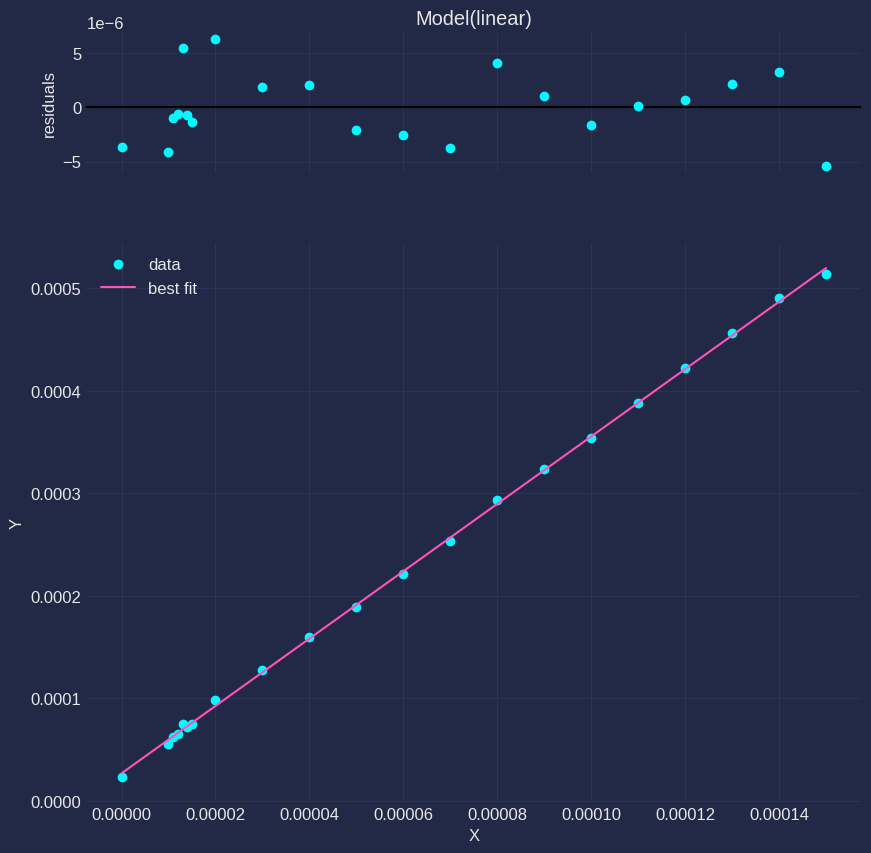

In [276]:
## First the fit. Try the whole data set first.
# The data seems fairly linear, lets try fitting first.
shotparams = line_fit_and_plot(shot['Emission Current (A)'], shot['Vms'])



In [277]:

## and the slope of the data is:
shot_slope_inclusive = get_uslope(shotparams)
shot_slope_inclusive


3.28674300654674+/-0.014748286981550951

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 7
    # variables        = 2
    chi-square         = 4.4992e-11
    reduced chi-square = 8.9984e-12
    Akaike info crit   = -176.393090
    Bayesian info crit = -176.501270
    R-squared          = 0.97744034
[[Variables]]
    slope:      3.58792818 +/- 0.24376977 (6.79%) (init = 3.587928)
    intercept:  2.2700e-05 +/- 2.8473e-06 (12.54%) (init = 2.270023e-05)


3.5879281820754727+/-0.2437697702576206

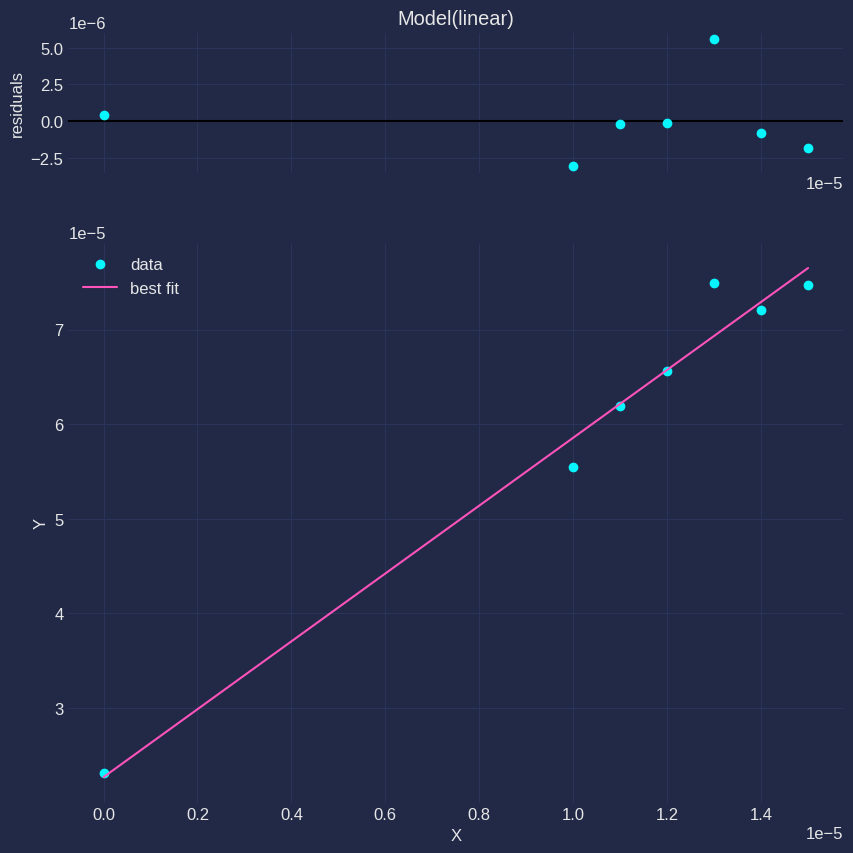

In [278]:
# Next, lets only get the data we collected more of.
# We collected extra data from .01 - .015, so lets first split the data

shot_small = shot.iloc[0:7]
shot_small_params = line_fit_and_plot(shot_small['Emission Current (A)'], shot_small['Vms'])
shot_small_slope = get_uslope(shot_small_params)
shot_small_slope




### Calculate Electron Charge

> Use the fit results, propagate the uncertainty, and find a value for $e$.

The equation given is:
$$I_{shot} = \sqrt{2eI_{emi}B}$$

The slope we found is $V^2/I$, so lets use that to find e.

In [283]:
## Calculate e with uncertainty and print it (with units) 
## Compare with the accepted value

# You will need the correct sensing resistance in the shot noise box:
# Older box:
# R_load = unc.ufloat(4976,1) # Load resistance of shot noise box in ohms 
# Newer box:
R_load = unc.ufloat(10000.0,10)

# e_1 = .5 * (1000 * R_load ** 2) ** -1 * shot_slope_inclusive # This is mA
e_1 = (1 / (2 * (G ** 2) * 1000 * (R_load ** 2))) * shot_slope_inclusive

e_2 = (1 / (2 * (G ** 2) * 1000 * (R_load ** 2))) * shot_small_slope

# We have th



# Calculate the result, and propagate the uncertainty.

# Use whatever you need below
print('\nElectron charge from whole data set = {:.2uP} C'.format(e_1))
print('Electron charge from partial data set = {:.2uP} C'.format(e_2))
# print('Electron charge from quadratic fit = {:.2uP} C'.format(e_3))
print('\nAccepted value = {:.4g} C'.format(const.e))


Electron charge from whole data set = (1.604±0.014)×10⁻¹⁹ C
Electron charge from partial data set = (1.75±0.12)×10⁻¹⁹ C

Accepted value = 1.602e-19 C
